In [1]:
import cv2
import time
import numpy as np
from PIL import Image
import urllib.request

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from random import randint

from scipy import ndimage, misc
from scipy.spatial.distance import hamming

from selenium import webdriver

from auxiliary_function import draw_bounding_box, find_bounding_box, segment_pictures
import os

### Data processing
- load background / icons images
- generate the bounding boxes
- match background and icons based on found coordinates

In [6]:
def calculate_max_matching(target,icon,d):
    largest_val = 0
    for degree in range(0,360,d):
        tmp = ndimage.rotate(target, degree, reshape=False)
        res = cv2.matchTemplate(icon,tmp,cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        if max_val > largest_val:
            largest_val = max_val
    return largest_val

def load_background(input_path, sorting=False):
    image_path = os.path.join(input_path, "background.png")
    img_grey_3 = cv2.imread(image_path)
    color_threshold = 180
    main_pane=img_grey_3
    main_pane[main_pane<color_threshold] = 0
    main_pane[main_pane>=color_threshold] = 255

    main_pane = main_pane.astype(np.uint8)
    main_pane = cv2.cvtColor(main_pane, cv2.COLOR_BGR2GRAY)
    icons_rect_coordinates = find_bounding_box(main_pane, (20,20), (100,100),sort=False)
    if sorting:
        # icons_rect_coordinates = update_list(icons_rect_coordinates)
        icons_rect_coordinates.sort(key=lambda x:x[2] * x[3], reverse=True)
        if len(icons_rect_coordinates) > 3:
            icons_rect_coordinates = icons_rect_coordinates[:3]
    icons = segment_pictures(main_pane,icons_rect_coordinates,(30,30), offset=2)
    # draw_bounding_box(main_pane, icons_rect_coordinates)
    return main_pane, icons_rect_coordinates, icons

    
def load_icons(input_path):
    img_1 = cv2.imread(os.path.join(input_path, "item_1.png"))
    img_2 = cv2.imread(os.path.join(input_path, "item_2.png"))
    img_3 = cv2.imread(os.path.join(input_path, "item_3.png"))
    img_items = cv2.hconcat([img_1, img_2, img_3])
    img_items = img_items.astype(np.uint8)
    img_items = cv2.cvtColor(img_items, cv2.COLOR_BGR2GRAY)
    targets_rect_coordinates = find_bounding_box(img_items, (5,5), (100,100))
    defined_coordinates = [
        (4,4, 42, 42),
        (54,4, 42, 42),
        (104,4, 42, 42)
    ]
    targets_rect_coordinates = defined_coordinates
    targets = segment_pictures(img_items,targets_rect_coordinates,(30,30))

    # draw_bounding_box(img_items, targets_rect_coordinates)
    return img_items, targets_rect_coordinates, targets
    


In [7]:
def match(main_pane, icons_rect_coordinates, icons,
          img_items, targets_rect_coordinates, targets):
    error_state = 0
    if len(targets) != len(icons):
        print(f"number of targets and icons mismatch - {len(targets)} vs. {len(icons)}")
        print(f"=====FAILED TO MATCH!!!=====")
        error_state = 1
        return error_state
    else:
        print(f"targets - {len(targets)}")
        print(f"icons - {len(icons)}")
        pass
    similarity_matrix = []
    for target in targets:
        similarity_per_target = []
        for icon in icons:
            similarity_per_target.append(calculate_max_matching(target,icon,6))
        similarity_matrix.append(similarity_per_target)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20), gridspec_kw={'width_ratios': [3, 3]})
    
    ax1.imshow(main_pane)
    ax2.imshow(img_items)
    # Calculate Mapping

    target_candidates = [False for _ in range(len(targets))]
    icon_candidates = [False for _ in range(len(icons))]

    mapping = {}

    # Approach 1 (May not work, because collision may occur)
    # Using np.argsort(-arr)

    '''
    similarity_matrix = [[0.49798074, 0.61611921, 0.56135607, 0.43419564, 0.61747766],
                         [0.5085994 , 0.53169155, 0.70087528, 0.30092609, 0.53550088],
                         [0.62834615, 0.49904037, 0.46511394, 0.31213483, 0.46880326],
                         [0.53429979, 0.59877342, 0.56217539, 0.37746215, 0.73305559]]


    np.argsort(np.array(similarity_matrix),axis=1) = [[3, 0, 2, 1, 4],
                                                      [3, 0, 1, 4, 2],
                                                      [3, 2, 4, 1, 0],
                                                      [3, 0, 2, 1, 4]]

    In this approach, 
    First target matches with fifth icon
    Second target matches with second icon
    Third target matches with fist icon
    Fourth target matches with fifth icon

    Collision happens! As both first target and fourth target matches the same icon
    '''


    # Sort the flatted similarity matrix in descending order, and assign the pair between target and icon if both of them
    # havem't been assigned.
    arr = np.array(similarity_matrix).flatten()
    arg_sorted = np.argsort(-arr)

    for e in arg_sorted:
        col = e //len(icons)
        row = e % len(icons)

        if target_candidates[col] == False and icon_candidates[row] == False:
            target_candidates[col], icon_candidates[row] = True, True
            mapping[col] = row

    # Circling the most similar icon,
    # blue circle: first target
    # red circle: second target
    # yellow circle: third target
    # green circle: fourth target
    color_map = {1:'b',2:'r',3:'y',4:'g'}
    print(mapping)
    error_state = 0
    for key in mapping:
        x,y,w,h = icons_rect_coordinates[mapping[key]]

        # x,y is the coordinate of top left hand corner
        # Bounding box is 70x70, so centre of circle = (x+70/2, y+70/2), i.e. (x+35, y+35)
        centre_x = x+(w//2)
        centre_y = y+(h//2)
        # Plot circle
        try:
            circle = plt.Circle((centre_x,centre_y), 20, color=color_map[key+1], fill=False, linewidth=5)
            # Plot centre
            plt.plot([centre_x], [centre_y], marker='o', markersize=10, color="white")
            ax1.add_patch(circle)
        except KeyError:
            error_state = 1
            pass
    plt.show()
    if error_state==1:
        print("=====FAILED TO MATCH!!!=====")
    return error_state
    


### First run -

processing 0 folder
targets - 3
icons - 3
{2: 0, 1: 2, 0: 1}


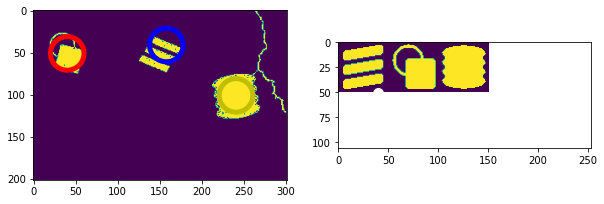

processing 1 folder
targets - 3
icons - 3
{2: 2, 0: 0, 1: 1}


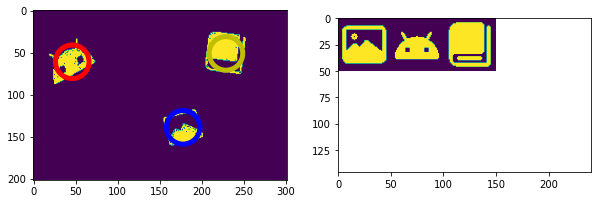

processing 2 folder
number of targets and icons mismatch - 3 vs. 4
=====FAILED TO MATCH!!!=====
processing 3 folder
targets - 3
icons - 3
{2: 2, 0: 1, 1: 0}


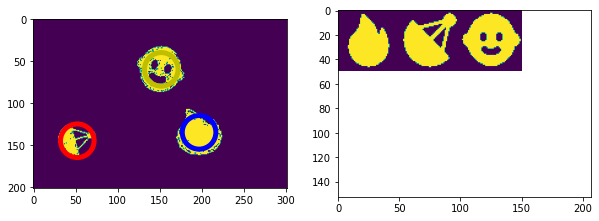

processing 4 folder
targets - 3
icons - 3
{2: 0, 1: 1, 0: 2}


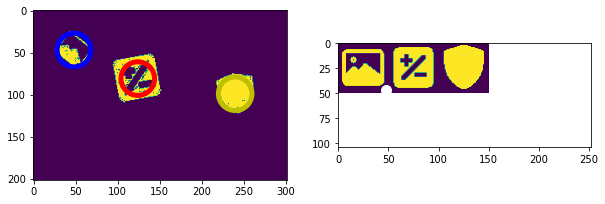

processing 5 folder
number of targets and icons mismatch - 3 vs. 8
=====FAILED TO MATCH!!!=====
processing 6 folder
targets - 3
icons - 3
{0: 2, 1: 1, 2: 0}


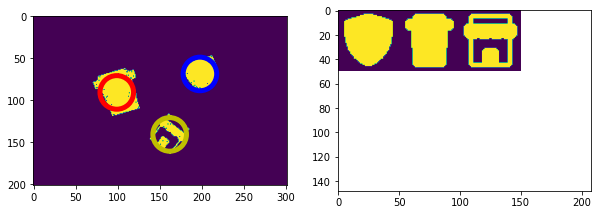

processing 7 folder
targets - 3
icons - 3
{1: 0, 0: 2, 2: 1}


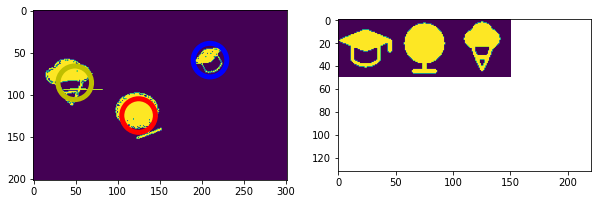

processing 8 folder
targets - 3
icons - 3
{0: 2, 2: 1, 1: 0}


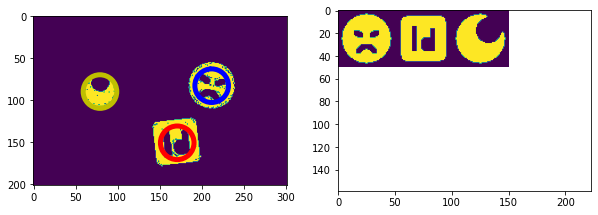

processing 9 folder
targets - 3
icons - 3
{1: 0, 0: 1, 2: 2}


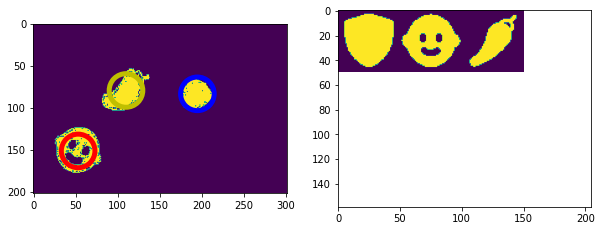

processing 10 folder
targets - 3
icons - 3
{0: 0, 1: 2, 2: 1}


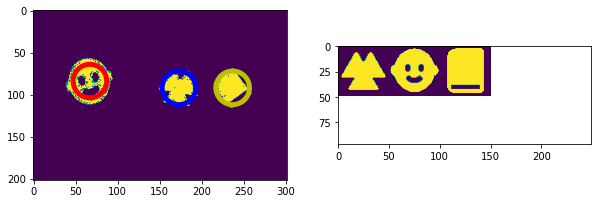

processing 11 folder
targets - 3
icons - 3
{2: 1, 1: 0, 0: 2}


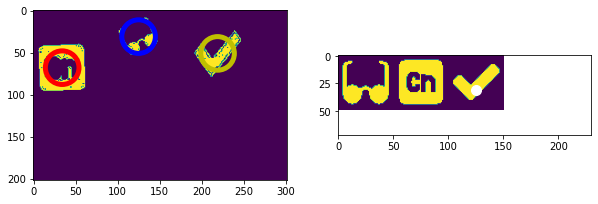

processing 12 folder
targets - 3
icons - 3
{1: 1, 0: 0, 2: 2}


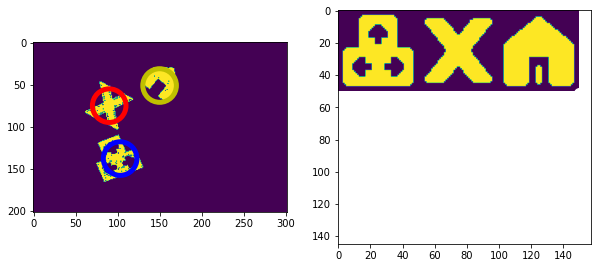

processing 13 folder
targets - 3
icons - 3
{1: 0, 0: 1, 2: 2}


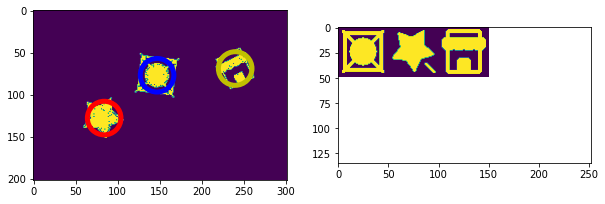

processing 14 folder
targets - 3
icons - 3
{1: 0, 2: 1, 0: 2}


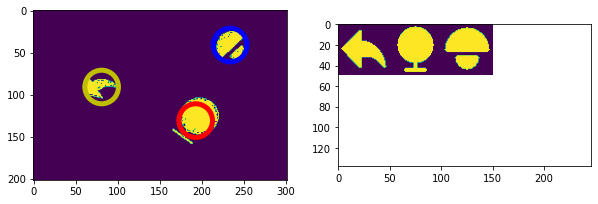

processing 15 folder
number of targets and icons mismatch - 3 vs. 6
=====FAILED TO MATCH!!!=====
processing 16 folder
targets - 3
icons - 3
{0: 0, 1: 2, 2: 1}


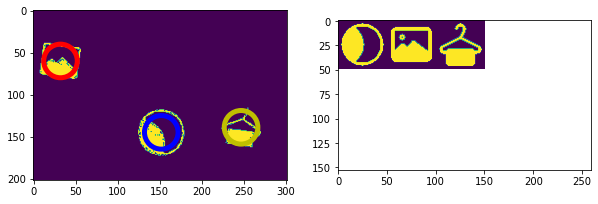

processing 17 folder
number of targets and icons mismatch - 3 vs. 6
=====FAILED TO MATCH!!!=====
processing 18 folder
number of targets and icons mismatch - 3 vs. 5
=====FAILED TO MATCH!!!=====
processing 19 folder
targets - 3
icons - 3
{0: 0, 1: 1, 2: 2}


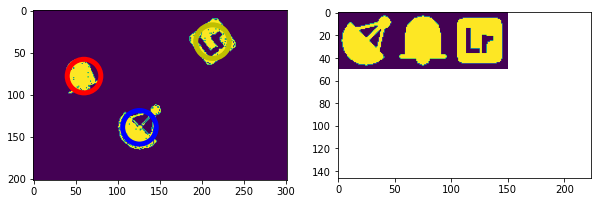

processing 20 folder
targets - 3
icons - 3
{0: 2, 1: 0, 2: 1}


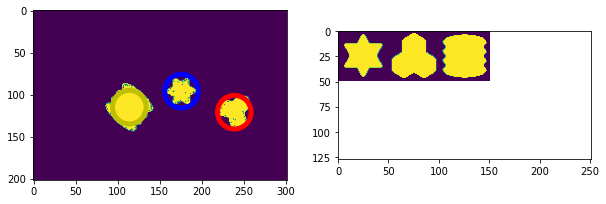

processing 21 folder
targets - 3
icons - 3
{2: 2, 0: 1, 1: 0}


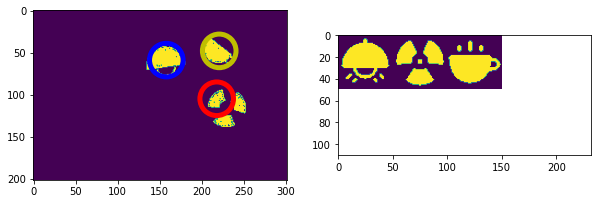

processing 22 folder
targets - 3
icons - 3
{1: 0, 2: 2, 0: 1}


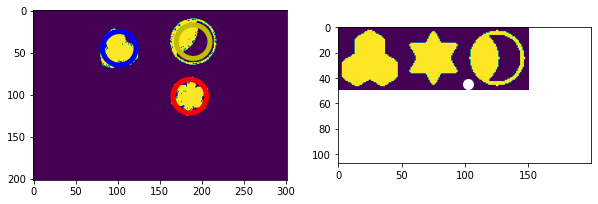

processing 23 folder
targets - 3
icons - 3
{1: 1, 2: 0, 0: 2}


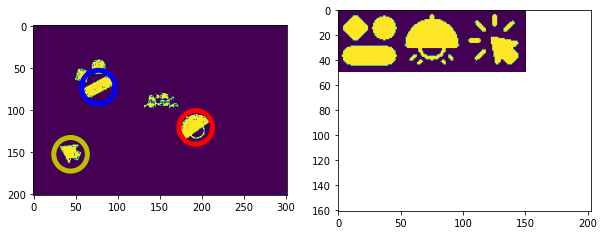

processing 24 folder
targets - 3
icons - 3
{2: 2, 0: 0, 1: 1}


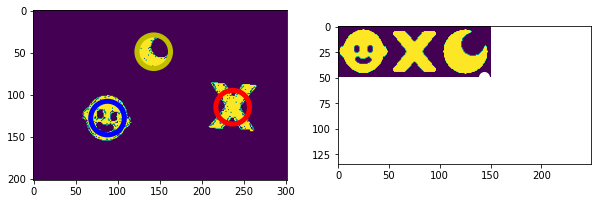

processing 25 folder
targets - 3
icons - 3
{2: 0, 0: 1, 1: 2}


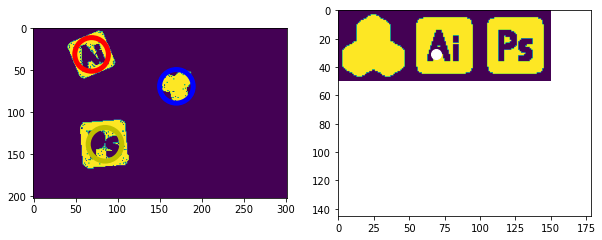

processing 26 folder
targets - 3
icons - 3
{1: 2, 2: 0, 0: 1}


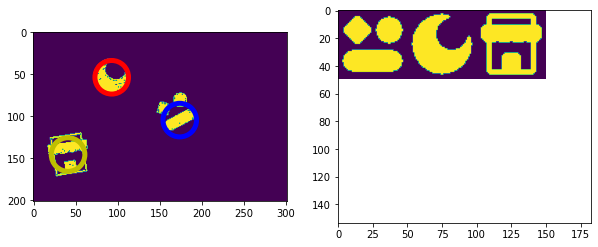

processing 27 folder
number of targets and icons mismatch - 3 vs. 2
=====FAILED TO MATCH!!!=====
processing 28 folder
targets - 3
icons - 3
{2: 1, 1: 0, 0: 2}


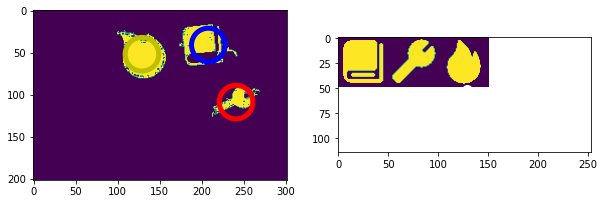

processing 29 folder
targets - 3
icons - 3
{2: 0, 1: 2, 0: 1}


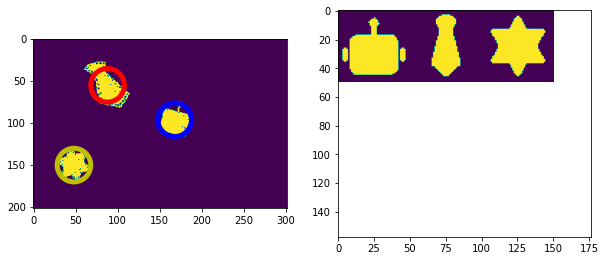

processing 30 folder
number of targets and icons mismatch - 3 vs. 4
=====FAILED TO MATCH!!!=====
processing 31 folder
targets - 3
icons - 3
{2: 2, 0: 0, 1: 1}


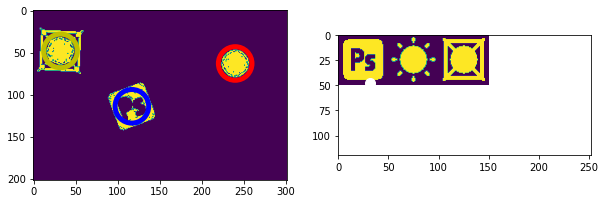

processing 32 folder
targets - 3
icons - 3
{1: 0, 2: 2, 0: 1}


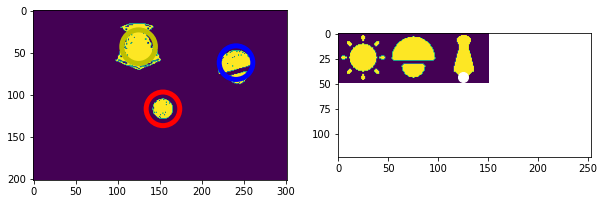

processing 33 folder
number of targets and icons mismatch - 3 vs. 2
=====FAILED TO MATCH!!!=====
processing 34 folder
targets - 3
icons - 3
{0: 0, 2: 2, 1: 1}


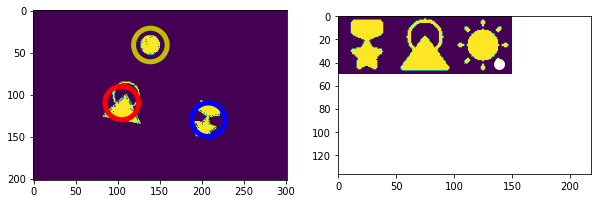

processing 35 folder
targets - 3
icons - 3
{0: 1, 2: 2, 1: 0}


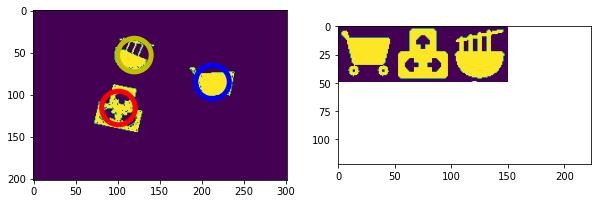

processing 36 folder
targets - 3
icons - 3
{0: 2, 1: 0, 2: 1}


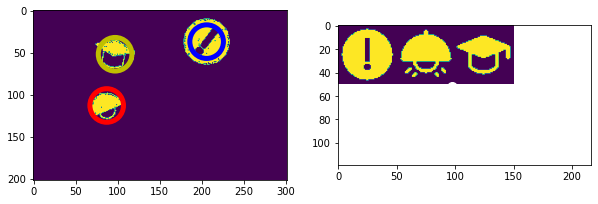

processing 37 folder
number of targets and icons mismatch - 3 vs. 4
=====FAILED TO MATCH!!!=====
processing 38 folder
targets - 3
icons - 3
{1: 0, 2: 1, 0: 2}


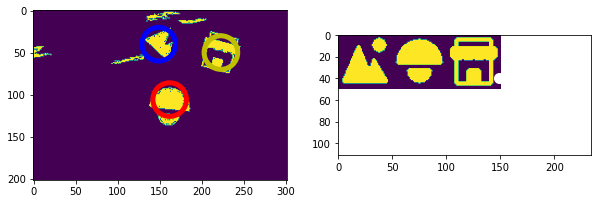

processing 39 folder
number of targets and icons mismatch - 3 vs. 2
=====FAILED TO MATCH!!!=====
processing 40 folder
targets - 3
icons - 3
{1: 1, 0: 2, 2: 0}


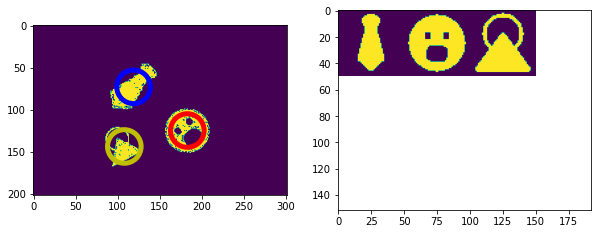

processing 41 folder
targets - 3
icons - 3
{1: 2, 2: 1, 0: 0}


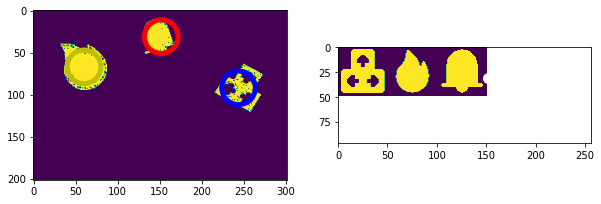

processing 42 folder
targets - 3
icons - 3
{0: 2, 1: 0, 2: 1}


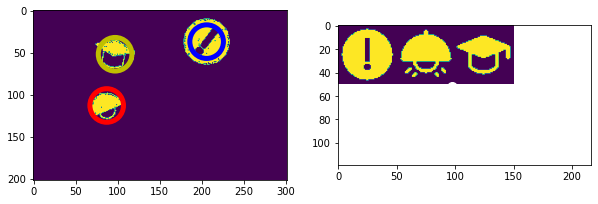

processing 43 folder
targets - 3
icons - 3
{2: 0, 1: 2, 0: 1}


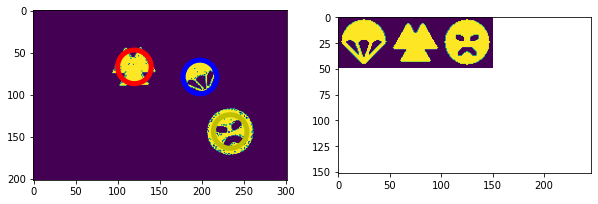

processing 44 folder
number of targets and icons mismatch - 3 vs. 2
=====FAILED TO MATCH!!!=====
processing 45 folder
number of targets and icons mismatch - 3 vs. 2
=====FAILED TO MATCH!!!=====
processing 46 folder
targets - 3
icons - 3
{0: 1, 2: 0, 1: 2}


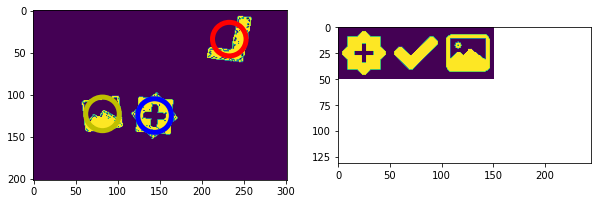

processing 47 folder
targets - 3
icons - 3
{1: 0, 2: 2, 0: 1}


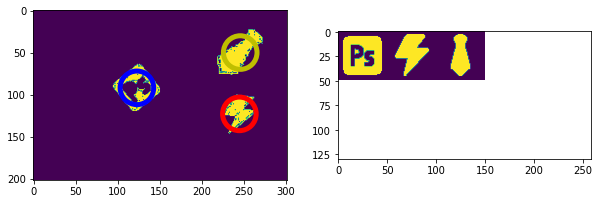

processing 48 folder
targets - 3
icons - 3
{2: 2, 1: 0, 0: 1}


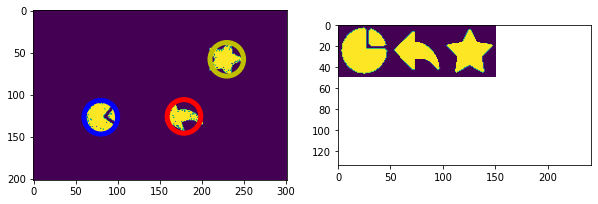

processing 49 folder
targets - 3
icons - 3
{1: 1, 0: 0, 2: 2}


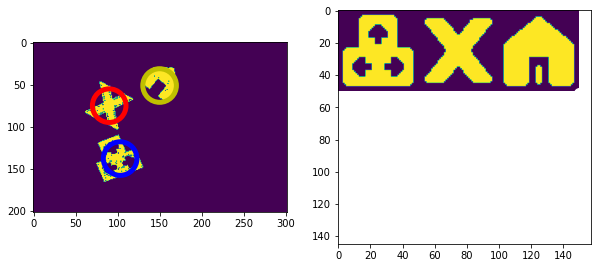

processing 50 folder
targets - 3
icons - 3
{1: 1, 2: 2, 0: 0}


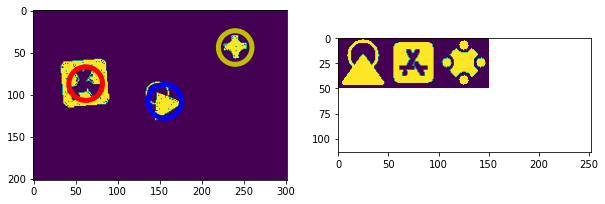

processing 51 folder
targets - 3
icons - 3
{0: 0, 1: 2, 2: 1}


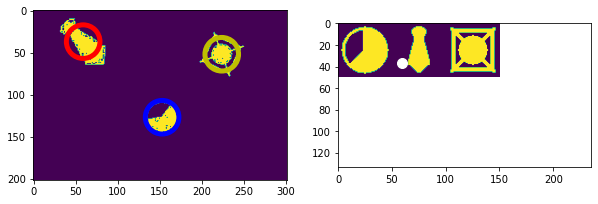

processing 52 folder
number of targets and icons mismatch - 3 vs. 2
=====FAILED TO MATCH!!!=====
processing 53 folder
number of targets and icons mismatch - 3 vs. 2
=====FAILED TO MATCH!!!=====
processing 54 folder
number of targets and icons mismatch - 3 vs. 4
=====FAILED TO MATCH!!!=====
processing 55 folder
number of targets and icons mismatch - 3 vs. 5
=====FAILED TO MATCH!!!=====
processing 56 folder
targets - 3
icons - 3
{2: 2, 0: 1, 1: 0}


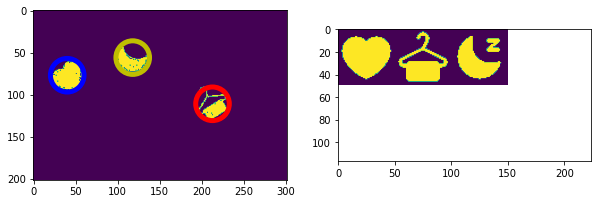

processing 57 folder
targets - 3
icons - 3
{0: 2, 2: 1, 1: 0}


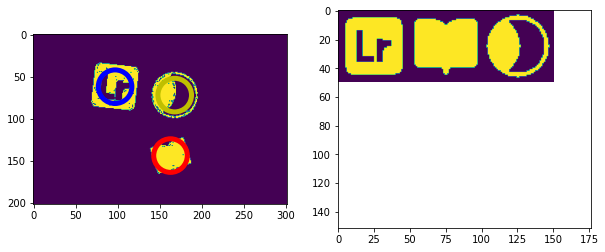

processing 58 folder
targets - 3
icons - 3
{1: 1, 0: 0, 2: 2}


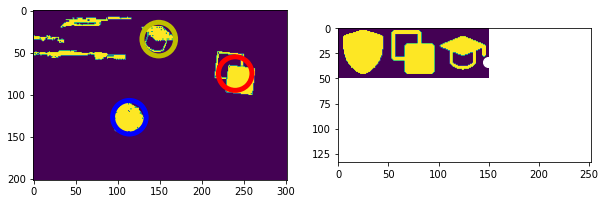

processing 59 folder
targets - 3
icons - 3
{2: 1, 1: 2, 0: 0}


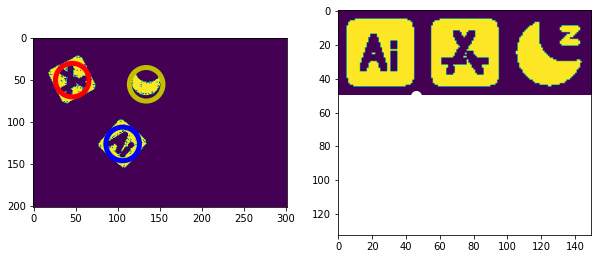

processing 60 folder
number of targets and icons mismatch - 3 vs. 4
=====FAILED TO MATCH!!!=====
processing 61 folder
targets - 3
icons - 3
{0: 1, 1: 2, 2: 0}


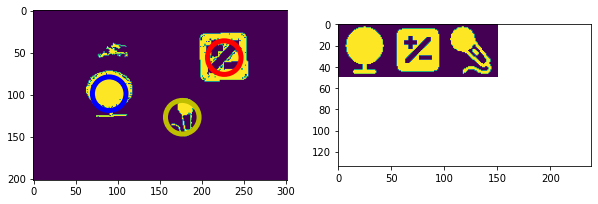

processing 62 folder
number of targets and icons mismatch - 3 vs. 5
=====FAILED TO MATCH!!!=====
processing 63 folder
targets - 3
icons - 3
{0: 1, 1: 2, 2: 0}


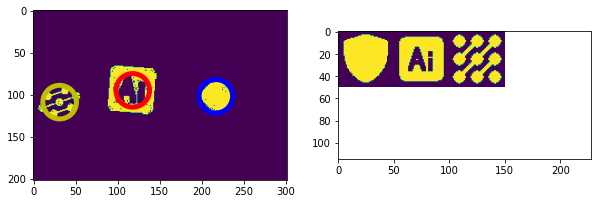

processing 64 folder
number of targets and icons mismatch - 3 vs. 2
=====FAILED TO MATCH!!!=====
processing 65 folder
number of targets and icons mismatch - 3 vs. 4
=====FAILED TO MATCH!!!=====
processing 66 folder
targets - 3
icons - 3
{1: 2, 2: 0, 0: 1}


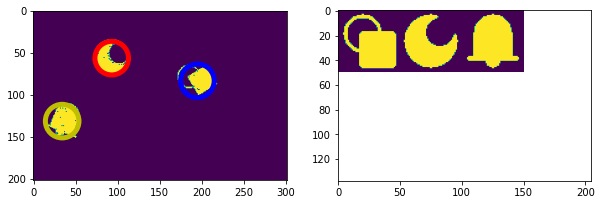

processing 67 folder
targets - 3
icons - 3
{1: 2, 2: 0, 0: 1}


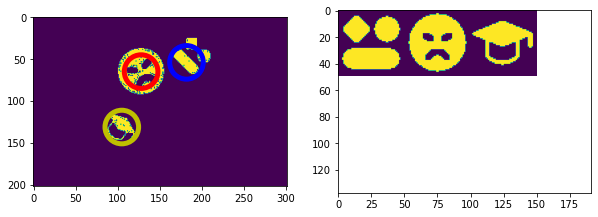

processing 68 folder
targets - 3
icons - 3
{1: 2, 0: 0, 2: 1}


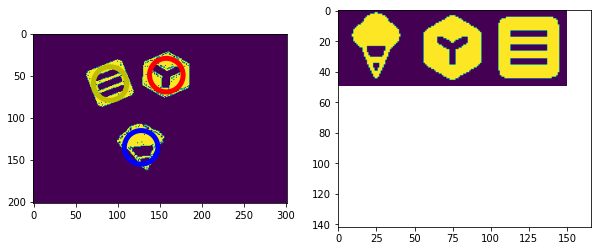

processing 69 folder
number of targets and icons mismatch - 3 vs. 4
=====FAILED TO MATCH!!!=====
processing 70 folder
targets - 3
icons - 3
{2: 1, 0: 2, 1: 0}


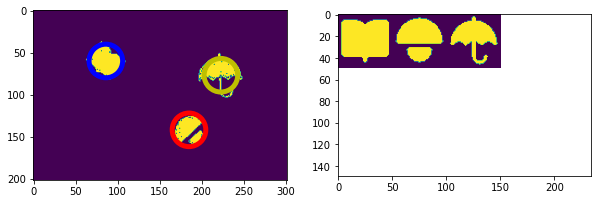

processing 71 folder
number of targets and icons mismatch - 3 vs. 4
=====FAILED TO MATCH!!!=====
processing 72 folder
number of targets and icons mismatch - 3 vs. 2
=====FAILED TO MATCH!!!=====
processing 73 folder
targets - 3
icons - 3
{0: 0, 1: 2, 2: 1}


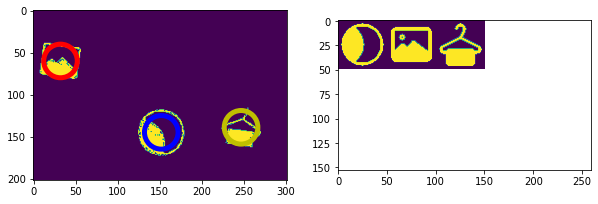

processing 74 folder
number of targets and icons mismatch - 3 vs. 2
=====FAILED TO MATCH!!!=====
processing 75 folder
number of targets and icons mismatch - 3 vs. 2
=====FAILED TO MATCH!!!=====
processing 76 folder
targets - 3
icons - 3
{1: 2, 0: 0, 2: 1}


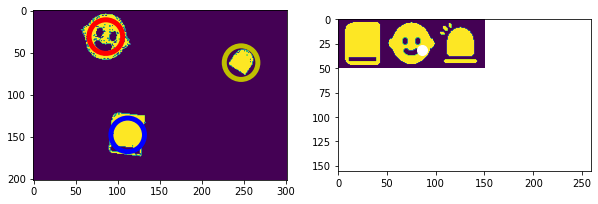

processing 77 folder
targets - 3
icons - 3
{2: 2, 1: 1, 0: 0}


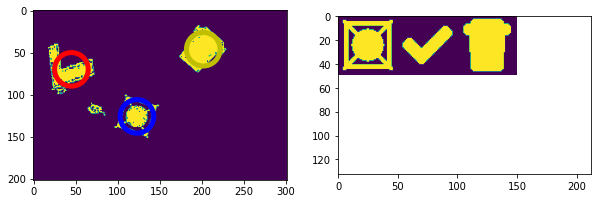

processing 78 folder
number of targets and icons mismatch - 3 vs. 5
=====FAILED TO MATCH!!!=====
processing 79 folder
targets - 3
icons - 3
{0: 1, 1: 0, 2: 2}


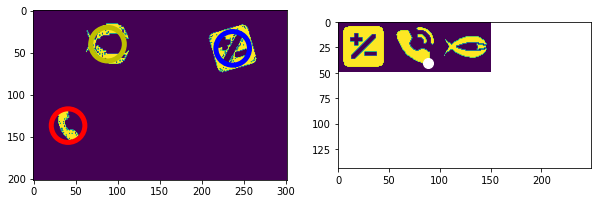

processing 80 folder
targets - 3
icons - 3
{0: 1, 2: 0, 1: 2}


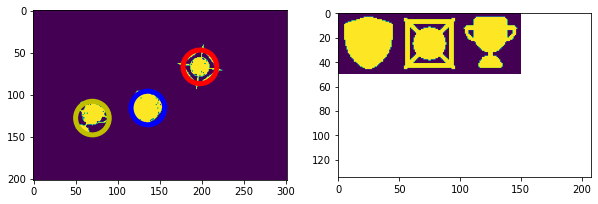

processing 81 folder
targets - 3
icons - 3
{0: 2, 1: 1, 2: 0}


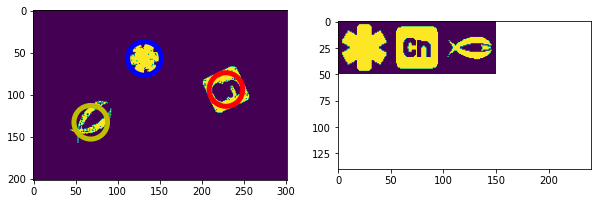

processing 82 folder
targets - 3
icons - 3
{0: 2, 2: 0, 1: 1}


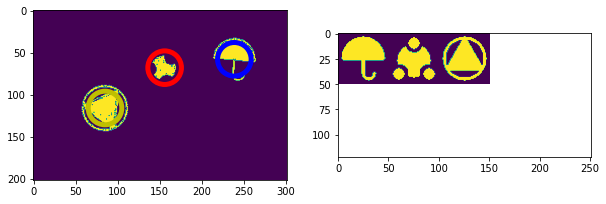

processing 83 folder
targets - 3
icons - 3
{1: 1, 2: 2, 0: 0}


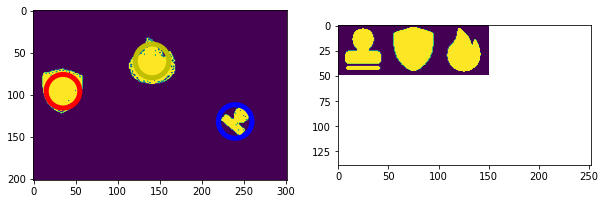

processing 84 folder
targets - 3
icons - 3
{1: 0, 0: 1, 2: 2}


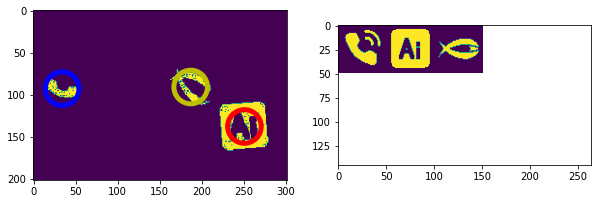

processing 85 folder
number of targets and icons mismatch - 3 vs. 2
=====FAILED TO MATCH!!!=====
processing 86 folder
number of targets and icons mismatch - 3 vs. 4
=====FAILED TO MATCH!!!=====
processing 87 folder
targets - 3
icons - 3
{1: 1, 0: 2, 2: 0}


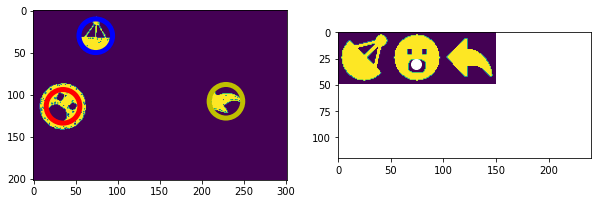

processing 88 folder
targets - 3
icons - 3
{0: 0, 1: 1, 2: 2}


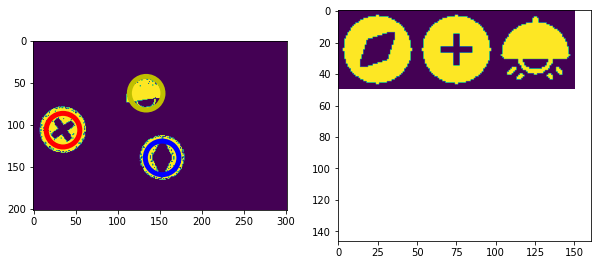

processing 89 folder
targets - 3
icons - 3
{2: 1, 0: 2, 1: 0}


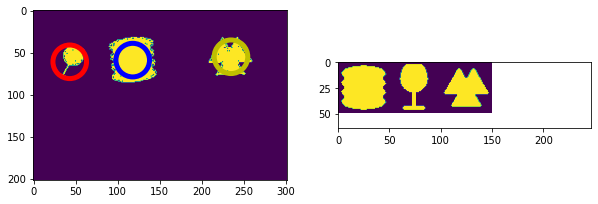

processing 90 folder
targets - 3
icons - 3
{0: 1, 2: 2, 1: 0}


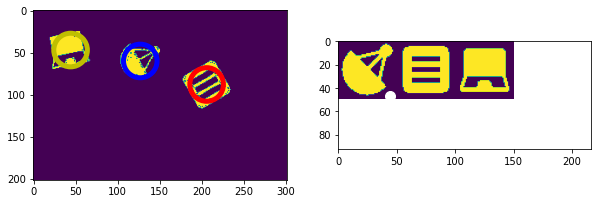

processing 91 folder
targets - 3
icons - 3
{1: 0, 2: 2, 0: 1}


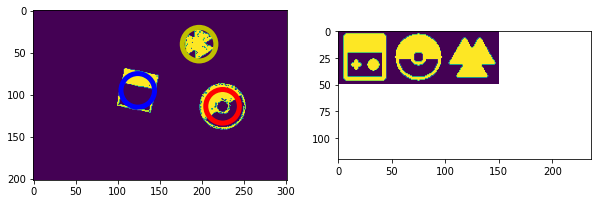

processing 92 folder
number of targets and icons mismatch - 3 vs. 4
=====FAILED TO MATCH!!!=====
processing 93 folder
targets - 3
icons - 3
{1: 1, 0: 0, 2: 2}


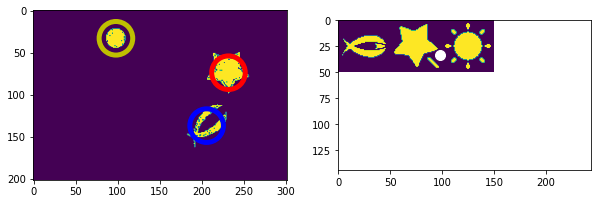

processing 94 folder
targets - 3
icons - 3
{2: 2, 1: 0, 0: 1}


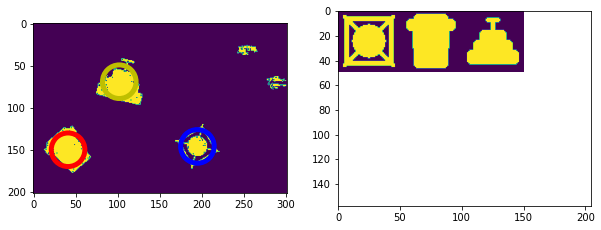

processing 95 folder
targets - 3
icons - 3
{2: 2, 1: 1, 0: 0}


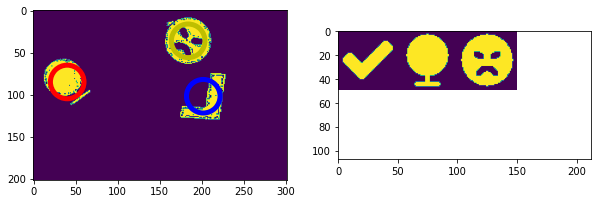

processing 96 folder
targets - 3
icons - 3
{0: 1, 1: 2, 2: 0}


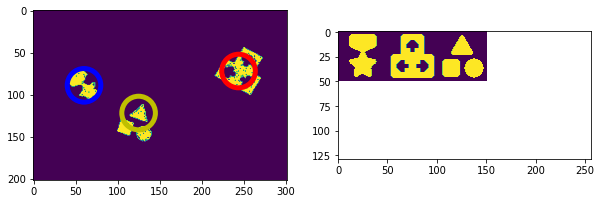

processing 97 folder
number of targets and icons mismatch - 3 vs. 2
=====FAILED TO MATCH!!!=====
processing 98 folder
targets - 3
icons - 3
{0: 1, 2: 0, 1: 2}


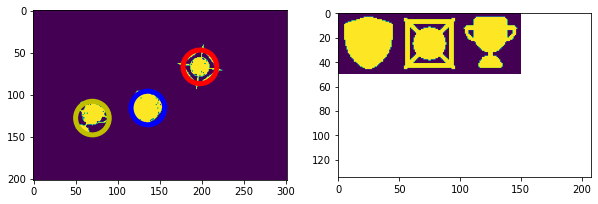

processing 99 folder
targets - 3
icons - 3
{0: 0, 2: 1, 1: 2}


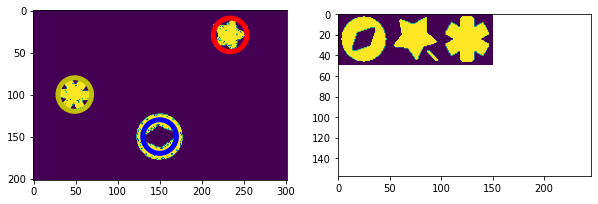

CPU times: user 29.9 s, sys: 14.5 s, total: 44.4 s
Wall time: 15.9 s


In [8]:
%%time
num_of_failure = 0
num_of_images = 100
list_failed = []
for i in range (num_of_images):
    print(f"processing {i} folder")
    input_path = f"/Users/kakarosa/workspace/crabada/images_sift_new_{i}/"
    main_pane, icons_rect_coordinates, icons = load_background(input_path)
    img_items, targets_rect_coordinates, targets = load_icons(input_path)
    
    error_state = match(main_pane, icons_rect_coordinates, icons, img_items, targets_rect_coordinates, targets)
    if error_state:
        list_failed.append(i)
    num_of_failure += error_state


## Order of circle:
# blue circle: first target
# red circle: second target
# yellow circle: third target
# green circle: fourth target


In [9]:
## Check the results
print(f"Processed {num_of_images} images. Failed {num_of_failure}")

Processed 100 images. Failed 30


### Second run - preprocessing the coordinates list

Rerun experiments on the failed cases from the last run, now, with preprocessing the coordinates list.

In [11]:
print(list_failed)

[2, 5, 15, 17, 18, 27, 30, 33, 37, 39, 44, 45, 52, 53, 54, 55, 60, 62, 64, 65, 69, 71, 72, 74, 75, 78, 85, 86, 92, 97]


processing 2 folder
targets - 3
icons - 3
{0: 1, 1: 0, 2: 2}


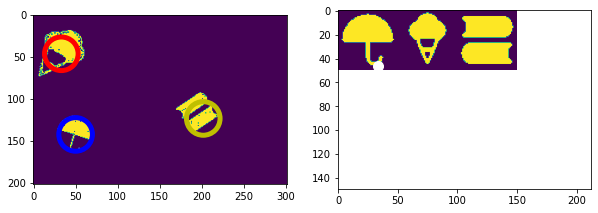

processing 5 folder
targets - 3
icons - 3
{0: 0, 1: 1, 2: 2}


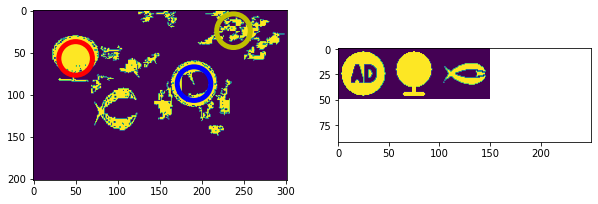

processing 15 folder
targets - 3
icons - 3
{0: 1, 2: 2, 1: 0}


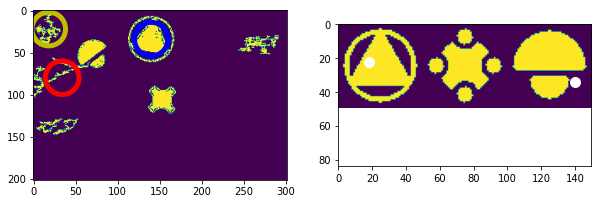

processing 17 folder
targets - 3
icons - 3
{0: 0, 1: 2, 2: 1}


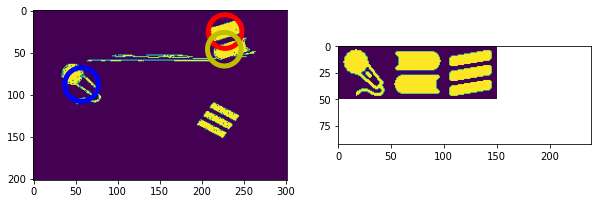

processing 18 folder
targets - 3
icons - 3
{0: 2, 2: 1, 1: 0}


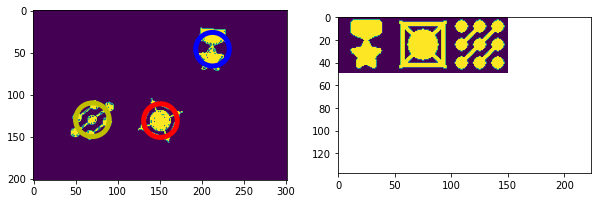

processing 27 folder
number of targets and icons mismatch - 3 vs. 2
=====FAILED TO MATCH!!!=====
processing 30 folder
targets - 3
icons - 3
{1: 0, 0: 2, 2: 1}


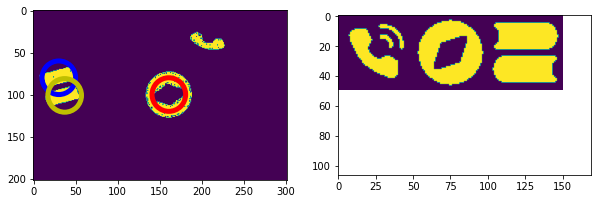

processing 33 folder
number of targets and icons mismatch - 3 vs. 2
=====FAILED TO MATCH!!!=====
processing 37 folder
targets - 3
icons - 3
{0: 0, 1: 2, 2: 1}


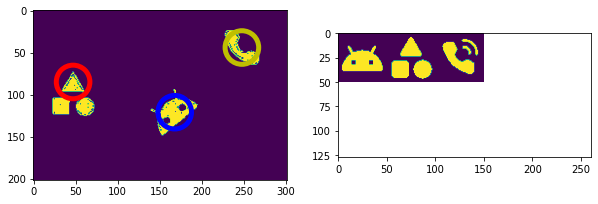

processing 39 folder
number of targets and icons mismatch - 3 vs. 2
=====FAILED TO MATCH!!!=====
processing 44 folder
number of targets and icons mismatch - 3 vs. 2
=====FAILED TO MATCH!!!=====
processing 45 folder
number of targets and icons mismatch - 3 vs. 2
=====FAILED TO MATCH!!!=====
processing 52 folder
number of targets and icons mismatch - 3 vs. 2
=====FAILED TO MATCH!!!=====
processing 53 folder
number of targets and icons mismatch - 3 vs. 2
=====FAILED TO MATCH!!!=====
processing 54 folder
targets - 3
icons - 3
{0: 1, 2: 0, 1: 2}


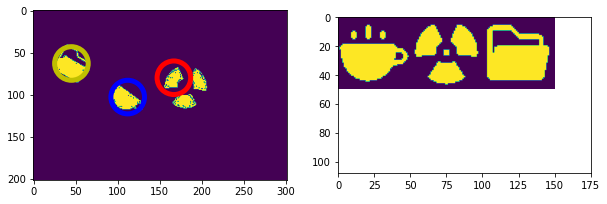

processing 55 folder
targets - 3
icons - 3
{2: 1, 0: 0, 1: 2}


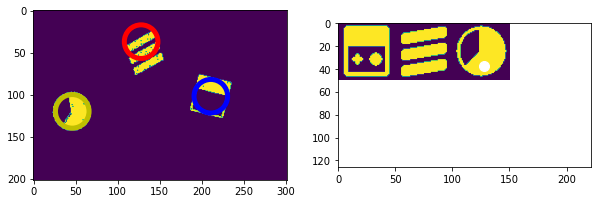

processing 60 folder
targets - 3
icons - 3
{0: 1, 1: 0, 2: 2}


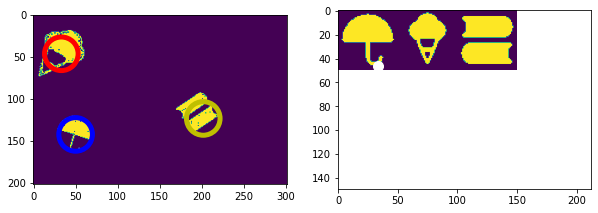

processing 62 folder
targets - 3
icons - 3
{1: 2, 2: 0, 0: 1}


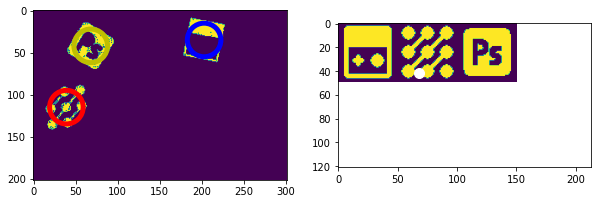

processing 64 folder
number of targets and icons mismatch - 3 vs. 2
=====FAILED TO MATCH!!!=====
processing 65 folder
targets - 3
icons - 3
{1: 1, 2: 0, 0: 2}


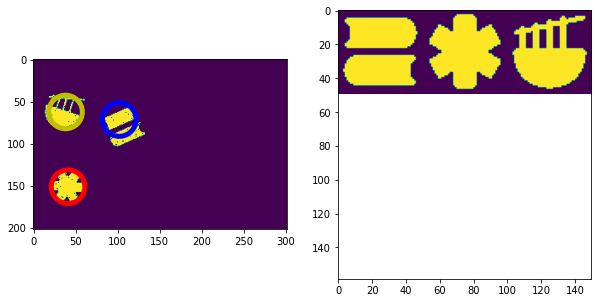

processing 69 folder
targets - 3
icons - 3
{2: 1, 1: 0, 0: 2}


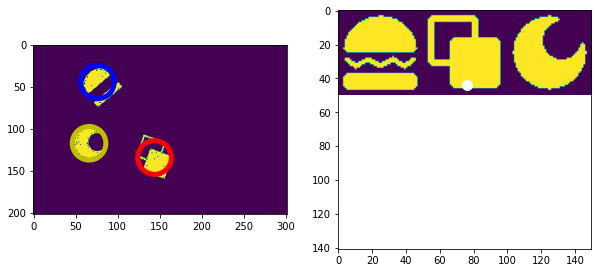

processing 71 folder
targets - 3
icons - 3
{1: 0, 0: 1, 2: 2}


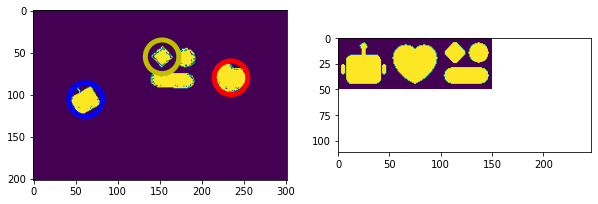

processing 72 folder
number of targets and icons mismatch - 3 vs. 2
=====FAILED TO MATCH!!!=====
processing 74 folder
number of targets and icons mismatch - 3 vs. 2
=====FAILED TO MATCH!!!=====
processing 75 folder
number of targets and icons mismatch - 3 vs. 2
=====FAILED TO MATCH!!!=====
processing 78 folder
targets - 3
icons - 3
{1: 0, 2: 1, 0: 2}


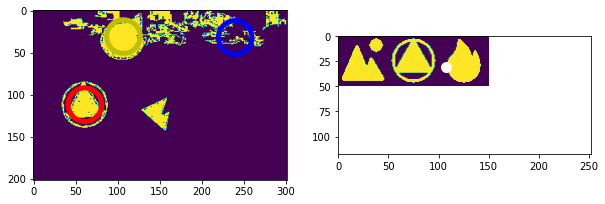

processing 85 folder
number of targets and icons mismatch - 3 vs. 2
=====FAILED TO MATCH!!!=====
processing 86 folder
targets - 3
icons - 3
{0: 1, 1: 2, 2: 0}


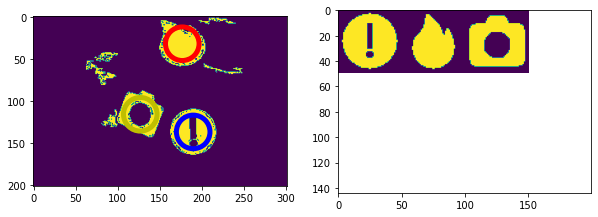

processing 92 folder
targets - 3
icons - 3
{0: 1, 1: 0, 2: 2}


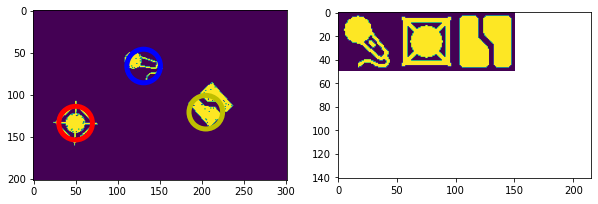

processing 97 folder
number of targets and icons mismatch - 3 vs. 2
=====FAILED TO MATCH!!!=====
CPU times: user 7.21 s, sys: 3.63 s, total: 10.8 s
Wall time: 3.95 s


In [12]:
%%time
num_of_failure = 0
list_failed_after = []
for i in list_failed:
    print(f"processing {i} folder")
    input_path = f"/Users/kakarosa/workspace/crabada/images_sift_new_{i}/"
    main_pane, icons_rect_coordinates, icons = load_background(input_path, sorting=True)
    img_items, targets_rect_coordinates, targets = load_icons(input_path)
    
    error_state = match(main_pane, icons_rect_coordinates, icons, img_items, targets_rect_coordinates, targets)
    if error_state:
        list_failed_after.append(i)
    num_of_failure += error_state

# blue circle: first target
# red circle: second target
# yellow circle: third target
# green circle: fourth target


In [13]:
print(list_failed_after)

[27, 33, 39, 44, 45, 52, 53, 64, 72, 74, 75, 85, 97]


## Conclusions:
- 13 images failed to recognize from list of 100
- 5 images are falsely recognized (checked from the second run.

### Next steps:
- deal with large noisy area
- deal with fragmented icons


In [14]:
list_failed_after

[27, 33, 39, 44, 45, 52, 53, 64, 72, 74, 75, 85, 97]